# Prediction Models 
In this notebook, I undertake feature engineering and data preprocessing, before creating models for prediction of late returns. 

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#imports" data-toc-modified-id="imports-1">imports</a></span></li><li><span><a href="#loading-data" data-toc-modified-id="loading-data-2">loading data</a></span><ul class="toc-item"><li><span><a href="#renaming-ID-variables,-for-easier-merging" data-toc-modified-id="renaming-ID-variables,-for-easier-merging-2.1">renaming ID variables, for easier merging</a></span></li></ul></li><li><span><a href="#feature-engineering" data-toc-modified-id="feature-engineering-3">feature engineering</a></span><ul class="toc-item"><li><span><a href="#dropping-variables-irrelevant-to-the-problem" data-toc-modified-id="dropping-variables-irrelevant-to-the-problem-3.1">dropping variables irrelevant to the problem</a></span></li><li><span><a href="#merging-into-single-dataframe" data-toc-modified-id="merging-into-single-dataframe-3.2">merging into single dataframe</a></span></li><li><span><a href="#dropping-missing-value" data-toc-modified-id="dropping-missing-value-3.3">dropping missing value</a></span></li><li><span><a href="#additional-feature:--distance-between-library-and-patron-addresses" data-toc-modified-id="additional-feature:--distance-between-library-and-patron-addresses-3.4">additional feature:  distance between library and patron addresses</a></span></li><li><span><a href="#converting-date-columns-to-datetime" data-toc-modified-id="converting-date-columns-to-datetime-3.5">converting date columns to datetime</a></span></li><li><span><a href="#comparing-mean-values-across-late-and-timely-returns" data-toc-modified-id="comparing-mean-values-across-late-and-timely-returns-3.6">comparing mean values across late and timely returns</a></span></li><li><span><a href="#examining-categorical-variables" data-toc-modified-id="examining-categorical-variables-3.7">examining categorical variables</a></span><ul class="toc-item"><li><span><a href="#gender" data-toc-modified-id="gender-3.7.1">gender</a></span></li><li><span><a href="#education" data-toc-modified-id="education-3.7.2">education</a></span></li><li><span><a href="#occupation" data-toc-modified-id="occupation-3.7.3">occupation</a></span></li><li><span><a href="#categories" data-toc-modified-id="categories-3.7.4">categories</a></span></li></ul></li></ul></li><li><span><a href="#data-preparation-for-ML-models" data-toc-modified-id="data-preparation-for-ML-models-4">data preparation for ML models</a></span><ul class="toc-item"><li><span><a href="#one-hot-encoding-categorical-variables" data-toc-modified-id="one-hot-encoding-categorical-variables-4.1">one-hot encoding categorical variables</a></span></li><li><span><a href="#separating-features-and-target" data-toc-modified-id="separating-features-and-target-4.2">separating features and target</a></span></li><li><span><a href="#generating-train-test-split" data-toc-modified-id="generating-train-test-split-4.3">generating train-test split</a></span></li></ul></li><li><span><a href="#MODEL-1:-Logistic-Regression-Model" data-toc-modified-id="MODEL-1:-Logistic-Regression-Model-5">MODEL 1: Logistic Regression Model</a></span><ul class="toc-item"><li><span><a href="#training" data-toc-modified-id="training-5.1">training</a></span></li><li><span><a href="#evaluation" data-toc-modified-id="evaluation-5.2">evaluation</a></span><ul class="toc-item"><li><span><a href="#accuracy" data-toc-modified-id="accuracy-5.2.1">accuracy</a></span></li><li><span><a href="#classification-report" data-toc-modified-id="classification-report-5.2.2">classification report</a></span></li><li><span><a href="#confusion-matrix" data-toc-modified-id="confusion-matrix-5.2.3">confusion matrix</a></span></li></ul></li></ul></li><li><span><a href="#MODEL-2:-Random-Forest" data-toc-modified-id="MODEL-2:-Random-Forest-6">MODEL 2: Random Forest</a></span><ul class="toc-item"><li><span><a href="#training" data-toc-modified-id="training-6.1">training</a></span></li><li><span><a href="#evaluation" data-toc-modified-id="evaluation-6.2">evaluation</a></span><ul class="toc-item"><li><span><a href="#accuracy" data-toc-modified-id="accuracy-6.2.1">accuracy</a></span></li><li><span><a href="#classification-report" data-toc-modified-id="classification-report-6.2.2">classification report</a></span></li><li><span><a href="#confusion-matrix" data-toc-modified-id="confusion-matrix-6.2.3">confusion matrix</a></span></li></ul></li></ul></li></ul></div>

## imports 

In [1]:
import os, sys, glob # for loading, saving and manipulating files on disk
from pathlib import Path # Path allows us to list directory paths in a manner that's not affected by the OS the notebook is being run on 

import pandas as pd # to work with csv files as dataframes 
import numpy as np # for mathematical and scientific computations 

import matplotlib.pyplot as plt # for plots 
import seaborn as sns # also for plotting, it's a wrapper for several matplotlib functions, making them more accessible 

from haversine import haversine, Unit # for computing distances between geocodes

from IPython.core.display import display, HTML # to change width of notebooks
display(HTML("<style>.container { width:100% !important; }</style>"))

## loading data

In [2]:
raw_data_dir = Path.home()/'projects'/'billups_data_challenge'/'Data Challenge' # specifies the directory with data files
cleaned_data_dir = raw_data_dir.parent/'cleaned_data' # directory for storing intermediate outputs such as cleaned data

In [3]:
lib_df = pd.read_csv(cleaned_data_dir/'libraries_cleaned_geocoded.csv')
books_checkouts_df = pd.read_csv(cleaned_data_dir/'books_checkouts_merged.csv')
customers_df = pd.read_csv(cleaned_data_dir/'customers_cleaned_geocoded.csv')

### renaming ID variables, for easier merging

In [4]:
lib_df.rename(columns={'id':'library_id', 'lat':'library_lat', 'long':'library_long', 'name':'library_name'}, inplace=True)
books_checkouts_df.rename(columns={'id':'book_id'}, inplace=True)
customers_df.rename(columns={'id':'patron_id', 'name':'patron_name', 'lat':'patron_lat', 'long':'patron_long'}, inplace=True)

## feature engineering

### dropping variables irrelevant to the problem

Certain variables do not contain information that would be useful for predicting late returns, or that information is already contained in other variables. Here I provide a brief description of such variables: 
- **library name**: the name of the library doesn't matter, it's already identified by the library ID. And it's location is geocoded 
- **customer name**: this variable has high cardinality, and I expect there to be no relation between names and later returns 
- **library address** & **customer address**: both of these are geocoded, so we can work with lat-long directly and don't need full addresses 
- **publisher**&**published date**: my prior is that publisher name doesn't affect late returns except through pages, prices, and categories, both of which are present as independent variables
- **author names** & **title**: again, my prior is that the variables through which authors may affect the late return, already exist in the data 
- **duration_borrowed_days**: this is not an irrelevant variable. This variable was generated using "date_returned" and therefore contains information that won't be available to the library when a book is being checked out, so using this variable would result in _data leakage_ in our model. 

In [5]:
lib_df = lib_df[['library_id', 'library_lat', 'library_long']]
books_checkouts_df.drop(columns=['publisher', 'authors', 'title', 'publishedDate', 'date_returned', 'return_year'], inplace=True)
customers_df = customers_df[['patron_id', 'patron_lat', 'patron_long', 'birth_date', 'gender', 'education', 'occupation']]

### merging into single dataframe

In [6]:
df = books_checkouts_df.merge(lib_df, on='library_id', how='outer')
df = df.merge(customers_df, on='patron_id', how='outer')

### dropping missing value
- during cleaning and EDA, I had imputed missing values wherever I could without influencing the target variable 
- I drop the remaining missing values

In [7]:
df = df.dropna(axis=0, how='any')

### additional feature:  distance between library and patron addresses 
 I want to create this feature, as I believe that the further the library is from patron homes, the more likely they might be to return late. 

In [8]:
df['library_loc'] = list(zip(df['library_lat'], df['library_long']))
df['patron_loc'] = list(zip(df['patron_lat'], df['patron_long']))

In [9]:
df['distance_lib_patron_km'] = df.apply(lambda x: haversine(x['library_loc'], x['patron_loc'], unit=Unit.METERS), axis=1)/1000

### converting date columns to datetime 

In [10]:
df[['date_checkout','date_due', 'birth_date']] = df[['date_checkout', 'date_due', 'birth_date']].apply(
lambda x: pd.to_datetime(x))

### comparing mean values across late and timely returns

In [11]:
df.groupby('late_return_indicator').mean()

,price,pages,checkout_year,duration_borrowed_days,due_date_is_holiday,closest_holiday_distance,library_lat,library_long,patron_lat,patron_long,distance_lib_patron_km
late_return_indicator,,,,,,,,,,,
0.0,293.267596,570.069056,2018.000000,16.068182,0.023601,13.308566,45.528661,-122.657048,45.536463,-122.654640,4.577098
1.0,338.028827,644.245810,1945.547486,26537.899441,0.044693,26391.726257,45.532124,-122.661357,45.528654,-122.654428,7.178853


- books with late returns are longer and costlier
- patrons associated with late returns on average live 3km further from the library 
- this table indicates that price, pages and distance are important features for predicting late returns

### examining categorical variables

In [12]:
df.select_dtypes(include='object').nunique()

book_id         199
categories       86
patron_id      1054
library_id       18
gender            8
education        31
occupation       56
library_loc      18
patron_loc     1005
dtype: int64

- there are 7 categorical variables 
- of these 7 variable, 3 are IDs, leaving us with 4 categorical variables: gender, education, occupation, categories
-  the cardinality of each of the 4 categorical columns seems high, so we reduce that 

#### gender

In [13]:
df['gender'].unique()

array(['male', 'female', ' male', ' female', 'MALE', 'FEMALE', 'male ',
       'female '], dtype=object)

In [14]:
df['gender'] = df['gender'].str.strip().str.upper()

In [15]:
df.groupby('gender').mean()

,price,pages,checkout_year,duration_borrowed_days,late_return_indicator,due_date_is_holiday,closest_holiday_distance,library_lat,library_long,patron_lat,patron_long,distance_lib_patron_km
gender,,,,,,,,,,,,
FEMALE,301.077023,573.468208,2010.690751,2692.099711,0.098266,0.023121,2673.776012,45.531178,-122.658292,45.539109,-122.654325,4.887249
MALE,297.400935,587.383518,2005.462758,4604.965135,0.175911,0.030111,4578.591125,45.526883,-122.656906,45.531346,-122.654925,4.975021


- Males are 8pp more likely to return books late

#### education

In [16]:
df['education'].fillna('edu_na', inplace=True)

In [17]:
df['education']= df['education'].str.strip().str.lower().apply(lambda x: ' '.join(x.split()))
df['education'] = df['education'].str.replace('other', 'edu_others')

In [18]:
df['education'].unique()

array(['college', 'graduate degree', 'high school', 'edu_otherss'],
      dtype=object)

In [19]:
df.groupby('education').mean()

,price,pages,checkout_year,duration_borrowed_days,late_return_indicator,due_date_is_holiday,closest_holiday_distance,library_lat,library_long,patron_lat,patron_long,distance_lib_patron_km
education,,,,,,,,,,,,
college,321.335367,598.463343,2008.803519,3379.445748,0.120235,0.046921,3360.307918,45.534497,-122.666923,45.541762,-122.661152,4.735814
edu_otherss,305.159151,579.572327,2006.106918,4366.069182,0.122642,0.028302,4342.342767,45.522567,-122.646747,45.531522,-122.648255,5.027692
graduate degree,286.089122,555.898649,2007.378378,3903.814189,0.121622,0.010135,3882.486486,45.527446,-122.657903,45.530473,-122.657937,4.839780
high school,284.529728,583.024457,2010.100543,2913.956522,0.171196,0.019022,2889.668478,45.531182,-122.658209,45.536841,-122.651367,5.094895


- patrons with college education most likely to return books late
- followed by patrons with high school education level 
- and then graduate degree holders

#### occupation

In [20]:
df['occupation'].fillna('job_na', inplace=True)

In [21]:
df['occupation'] = df['occupation'].str.strip().str.lower().apply(lambda x: ' '.join(x.split()))
df['occupation'] = df['occupation'].str.replace('other', 'job_others')

In [22]:
df['occupation'].unique()

array(['admin & support', 'sales', 'business & finance', 'tech',
       'blue collar', 'job_otherss', 'education & health'], dtype=object)

In [23]:
df.groupby('occupation').mean()

,price,pages,checkout_year,duration_borrowed_days,late_return_indicator,due_date_is_holiday,closest_holiday_distance,library_lat,library_long,patron_lat,patron_long,distance_lib_patron_km
occupation,,,,,,,,,,,,
admin & support,313.547273,596.868687,2005.525253,4580.303030,0.136364,0.020202,4553.560606,45.528892,-122.663095,45.530236,-122.661098,4.753122
blue collar,291.880988,590.679012,2007.709877,3774.672840,0.104938,0.024691,3759.827160,45.528321,-122.659564,45.541698,-122.656478,4.814882
business & finance,282.526120,549.588000,2011.204000,2508.756000,0.140000,0.012000,2488.772000,45.529024,-122.649086,45.549890,-122.649574,5.569794
education & health,312.732961,587.955307,2009.955307,2958.871508,0.111732,0.027933,2942.631285,45.528728,-122.648187,45.530458,-122.645725,4.370870
job_otherss,305.675372,591.260638,2010.271277,2844.446809,0.101064,0.026596,2825.563830,45.529602,-122.656191,45.533900,-122.649041,5.083202
sales,295.844675,578.112426,2000.497041,6417.994083,0.159763,0.053254,6386.195266,45.526795,-122.665924,45.521823,-122.657054,4.688871
tech,296.964746,576.892655,2010.757062,2678.220339,0.192090,0.028249,2651.129944,45.532418,-122.664983,45.534547,-122.665331,4.955877


- patrons working in sales most likely to return books late 

#### categories

In [24]:
df['categories'].unique()

array(["['Social Science']", "['Advertising']",
       "['Business & Economics']", "['Psychology']",
       "['Technology & Engineering']", "['Mechanics, Applied']",
       "['Technology']", "['Mechanical engineering']", "['Mechanics']",
       "['Medical']", "['Bacteriology']", "['Medicine']",
       "['Financial services industry']", "['Industries']",
       "['Banks and banking']", "['Political Science']",
       "['Desarrollo economico']", "['Fiction']",
       "['Internal combustion engines']", "['Science']", "['Philosophy']",
       "['Computers']", "['Water resources development']",
       "['United States']", "['Water-supply']", "['Natural resources']",
       "['Environmental law']", "['Mechanics, Analytic']",
       "['Electronic books']", "['Government publications']",
       "['Banking law']", "['Financial institutions']", "['Finance']",
       "['Corporations']", "['Diesel engines']", "['Transportation']",
       "['Juvenile Fiction']", "['Conservation of natural resources

- the cardinality of the categories variable is really high, so I try to create other categories using this. Primarily, fiction and non-fiction

In [25]:
df['categories'].fillna('n/a', inplace=True)

In [26]:
df['new_category'] = np.where(df['categories'].str.contains('Ficti'), 'Fiction', 'Non-Fiction')

In [27]:
df.drop(columns=['categories'], inplace=True)

In [28]:
df.groupby('new_category').mean()

,price,pages,checkout_year,duration_borrowed_days,late_return_indicator,due_date_is_holiday,closest_holiday_distance,library_lat,library_long,patron_lat,patron_long,distance_lib_patron_km
new_category,,,,,,,,,,,,
Fiction,276.424286,621.714286,2018.000000,19.142857,0.035714,0.000000,18.285714,45.526949,-122.65445,45.536594,-122.642726,4.170110
Non-Fiction,299.818849,579.205405,2007.985328,3681.953668,0.137452,0.027027,3659.329730,45.529177,-122.65770,45.535381,-122.654868,4.945522


- non-fiction books considerably more likely to be returned late than fiction books 

## data preparation for ML models 

### one-hot encoding categorical variables 

In [29]:
ohe_gender = pd.get_dummies(df['gender'])
ohe_education = pd.get_dummies(df['education'])
ohe_occupation = pd.get_dummies(df['occupation'])
ohe_book_category = pd.get_dummies(df['new_category'])

In [30]:
df = df.join([ohe_gender, ohe_education, ohe_occupation, ohe_book_category])

### separating features and target

In [32]:
y = df['late_return_indicator']
X = df.drop(columns=['book_id', 'patron_id', 'library_id', 'birth_date', 'library_loc', 'patron_loc', 
             'gender', 'occupation', 'education', 'new_category', 'late_return_indicator',  'date_checkout', 'date_due', 'duration_borrowed_days'])

### generating train-test split 

I want to split my test into three sets: 
- **Train** : these observations will be used to train the model to learn
- **Validation**: this subset serves the purpose of model selection. So, I want to be able to try different hyperparameters, and knowing which hyperparameters are better suited for my model would require me to "test" it on a dataset that is not seen. 
- **Test**: this is a hold-out set, used to indicate the final performance of the "best model" selected using the validation set performance

In [50]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.1, random_state=7) #10% of the data is held out 
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=7) # 1/4th of the training data is used for validation

## MODEL 1: Logistic Regression Model 

In [35]:
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.metrics import confusion_matrix, classification_report

### training 

In [36]:
m1_lr = LogisticRegression()
m1_lr.fit(X_train, y_train);

/Users/garima/miniconda3/envs/reloc/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


### evaluation

In [51]:
y_pred_m1 = m1_lr.predict(X_test) #using X_test and not X_val here because not tuning hyperparameters for logistic regression

NameError: name 'm1_lr' is not defined

#### accuracy

In [39]:
print(f"Accuracy of the LogisticRegression model is {round(m1_lr.score(X_test, y_test), 4)*100}%")

Accuracy of the LogisticRegression model is 93.05%
Accuracy of the LogisticRegression excluding 19th century checkouts is 92.09%


#### classification report

In [40]:
print(classification_report(y_test, y_pred_m1))

              precision    recall  f1-score   support

         0.0       0.93      0.99      0.96       283
         1.0       0.90      0.58      0.71        48

    accuracy                           0.93       331
   macro avg       0.92      0.79      0.83       331
weighted avg       0.93      0.93      0.92       331



#### confusion matrix 

<AxesSubplot:>

<AxesSubplot:>

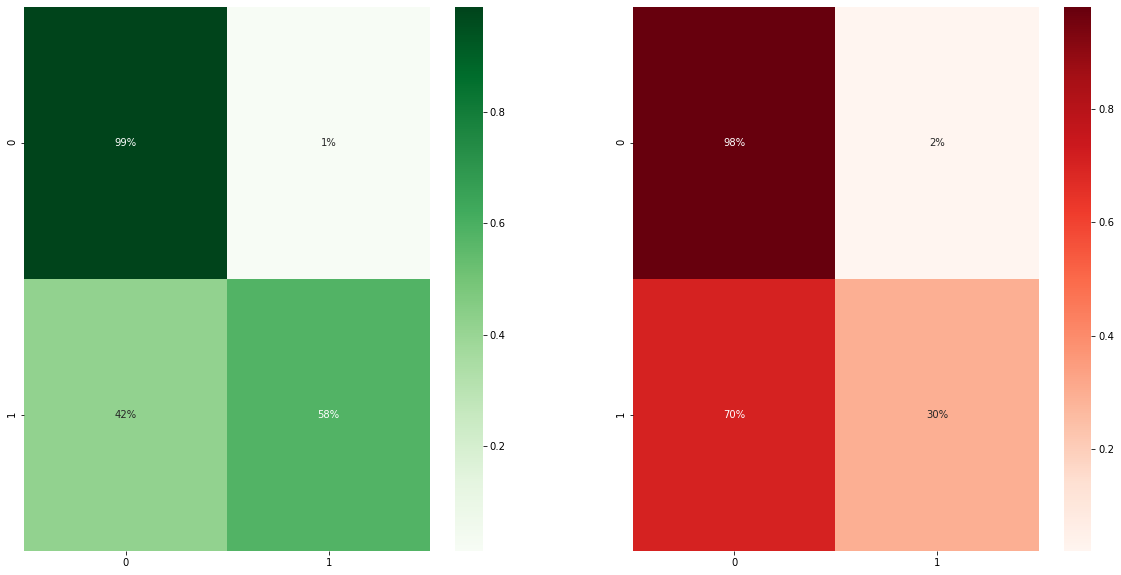

In [41]:
cm= confusion_matrix(y_test, y_pred_m1, normalize='true')
sns.heatmap(cm_a, annot=True, fmt='.0%', cmap='Greens')

The Logistic Regression model classifies timely returns as timely 99% of the time, and the late returns as late 62% of the time. Given that the library is interested in monitoring and predicting late returns, the metric we care most about is the recall value for late-returns. 

## MODEL 2: Random Forest

In [42]:
from sklearn.ensemble import RandomForestClassifier

### training

In [58]:
def get_best_max_depth(): 
    max_depth_accuracy = []
    for i in range(1,15): 
        model = RandomForestClassifier(max_depth=i, random_state=7)
        model.fit(X_train, y_train)
        max_depth_accuracy.append(model.score(X_val, y_val))
    max_accuracy = max(max_depth_accuracy)
    best_max_depth = max_depth_accuracy.index(max_accuracy)
    return best_max_depth

In [59]:
get_best_max_depth()

8

In [44]:
m2_rf= RandomForestClassifier(max_depth=get_best_max_depth(), random_state=7)
m2_rf.fit(X_train, y_train)

RandomForestClassifier(max_depth=9, random_state=7)

### evaluation

In [45]:
y_pred_m2 = m2_rf.predict(X_test)

#### accuracy

In [46]:
print(f"Accuracy of the Random Forest model is {round(m2_rf.score(X_test, y_test), 4)*100}%")

Accuracy of the Random Forest model is 97.28%


#### classification report

In [47]:
print(classification_report(y_test, y_pred_m2))

              precision    recall  f1-score   support

         0.0       0.97      1.00      0.98       283
         1.0       1.00      0.81      0.90        48

    accuracy                           0.97       331
   macro avg       0.98      0.91      0.94       331
weighted avg       0.97      0.97      0.97       331



#### confusion matrix 

<AxesSubplot:>

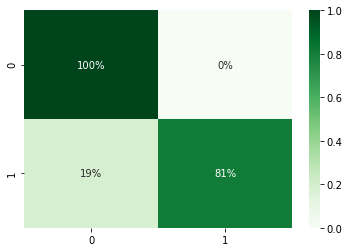

In [48]:
cm = confusion_matrix(y_test, y_pred_m2, normalize='true')
sns.heatmap(cm, annot=True, fmt='.0%', cmap='Greens')

<AxesSubplot:>

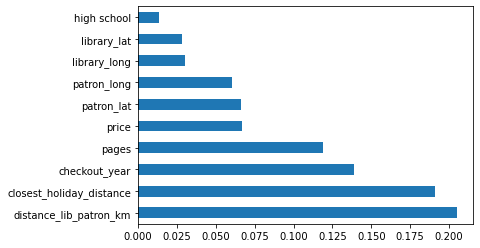

In [49]:
xx = pd.Series(m2_rf.feature_importances_, index=X.columns)
xx.sort_values(ascending=False, inplace=True)
xx.nlargest(10).plot(kind='barh')